# Feature Loss

In [0]:
from fastai import *
from fastai.tabular import *
import pandas as pd
from torchsummary import summary
import torch
from torch import nn
import imageio
import torch
import glob
from fastai.vision import *
import os
from torch import nn
import torch.nn.functional as F
from torchvision.models import vgg16_bn

## Data and Imports

In [0]:
colab = True
if colab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount = True)
  %cp "/content/drive/My Drive/autoencoder-training/model_layers.py" .
  %cp "/content/drive/My Drive/autoencoder-training/baseline_model.py" .
  %cp "/content/drive/My Drive/autoencoder-training/featureLoss_function.py" .
  import baseline_model
  import featureLoss_function
else: 
  os.chdir("../")
  image_path = os.getcwd() + "/data"
  from resnet_autoencoder_training import baseline_model
  from resnet_autoencoder_training import featureLoss_function

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
np.random.seed(3333)
torch.manual_seed(3333)

size = 32
batchsize = 128

path = untar_data(URLs.MNIST)
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=10, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0, 
                      p_lighting=0.75)
src = (ImageImageList.from_folder(path).split_by_folder("training", "testing").label_from_func(lambda x: x))
data = (src.transform(tfms, size=size, tfm_y=True).databunch(bs=batchsize).normalize(imagenet_stats, do_y = False))

## Model

In [0]:
vgg_m = vgg16_bn(True).features.cuda().eval()

requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]

base_loss = F.mse_loss

feat_loss = featureLoss_function.FeatureLoss(vgg_m, blocks[0:3], [30,20,10], base_loss)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [0]:
autoencoder = baseline_model.autoencoder()
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [0]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.162645,0.131430,0.005859,0.025580,01:48
1,0.081848,0.076257,0.002564,0.017500,01:49
2,0.063860,0.060103,0.001897,0.015195,01:48
3,0.052914,0.049349,0.001438,0.013154,01:48
4,0.048194,0.045443,0.001262,0.012304,01:49


In [0]:
learn.metrics = [mean_squared_error, mean_absolute_error, r2_score, explained_variance]

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,r2_score,explained_variance,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.92E-06
Min loss divided by 10: 1.00E-06


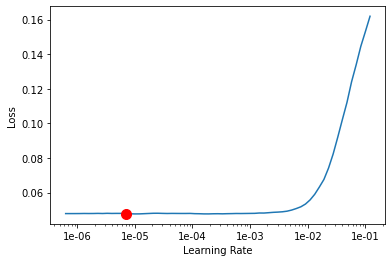

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(10, max_lr=1e-04)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,r2_score,explained_variance,time
0,0.047475,0.045271,0.001258,0.012288,0.984522,0.984527,01:49
1,0.047951,0.045136,0.001251,0.012255,0.984610,0.984617,01:48
2,0.047450,0.044782,0.001242,0.012218,0.984736,0.984741,01:49
3,0.047228,0.044273,0.001224,0.012136,0.984950,0.984970,01:49
4,0.046785,0.043879,0.001216,0.012094,0.985049,0.985053,01:49
5,0.045945,0.043449,0.001199,0.012018,0.985251,0.985254,01:46
6,0.045873,0.043086,0.001186,0.011945,0.985420,0.985424,01:49
7,0.045349,0.042846,0.001178,0.011907,0.985511,0.985517,01:46
8,0.045099,0.042730,0.001171,0.011870,0.985602,0.985605,01:43
9,0.044999,0.042706,0.001169,0.011859,0.985626,0.985630,01:42


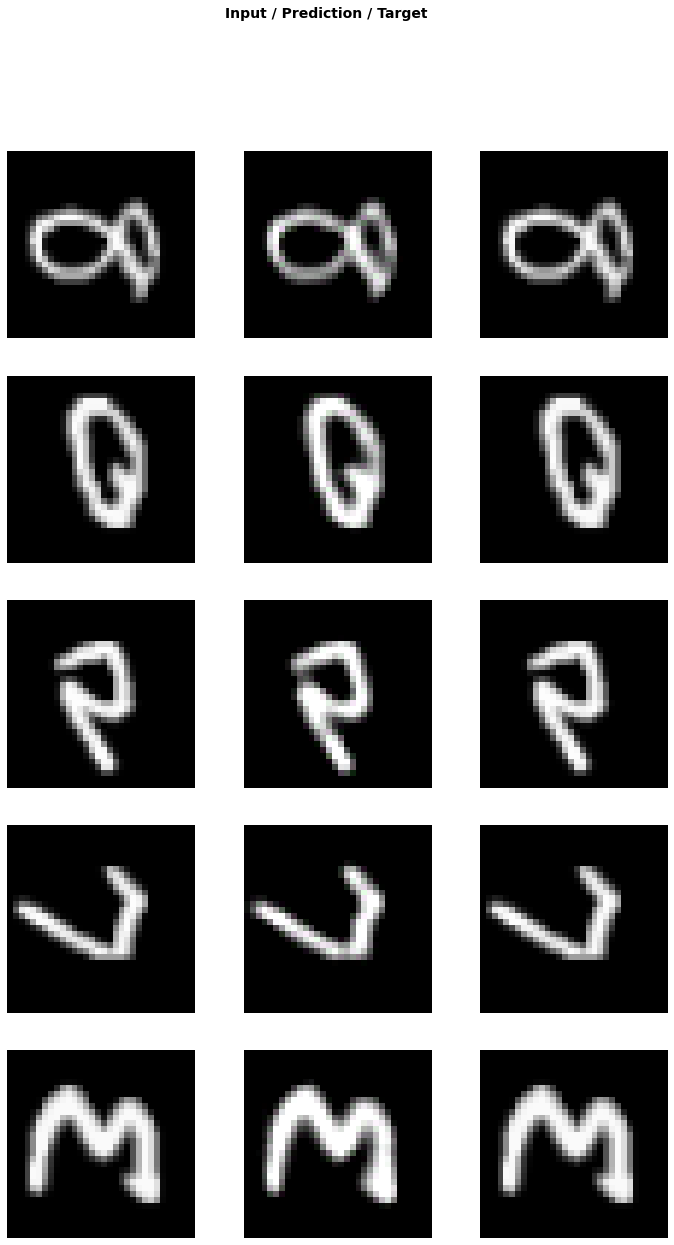

In [0]:
learn.show_results(ds_type=DatasetType.Train)

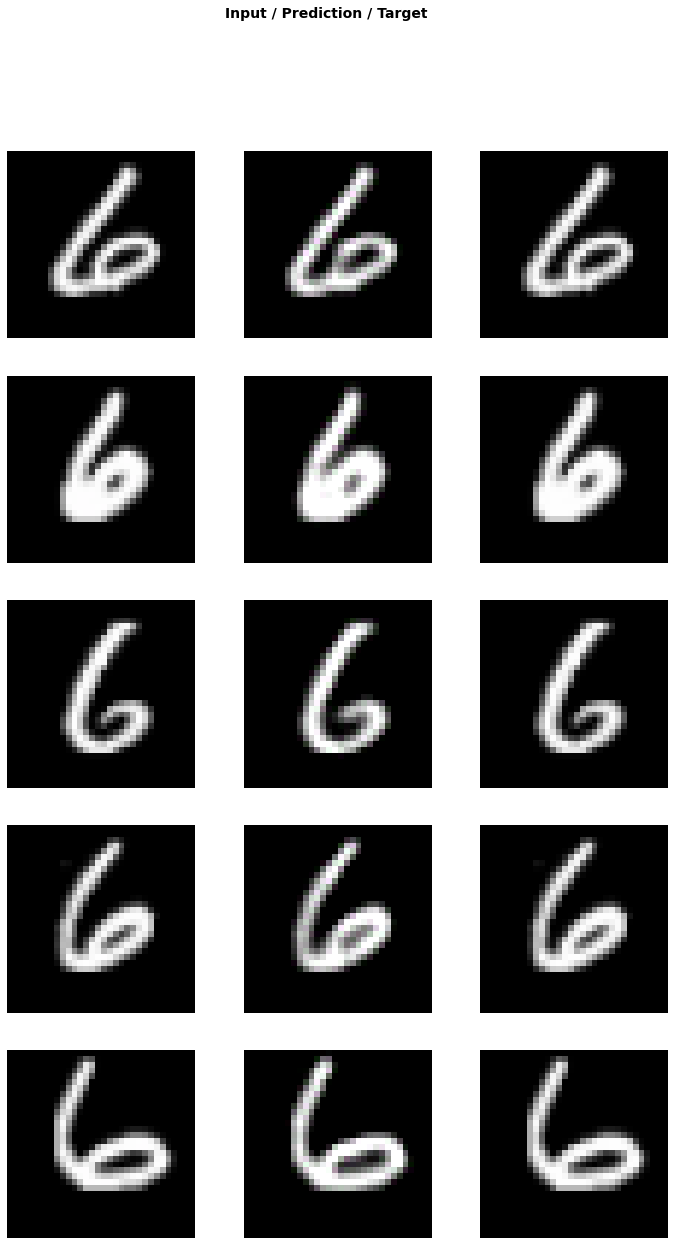

In [0]:
learn.show_results(ds_type=DatasetType.Valid)

In [0]:
torch.save(autoencoder, "/content/drive/My Drive/autoencoder-training/featureLoss-MNIST.pt")